# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.
/home/jin/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


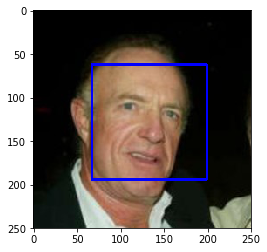

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.
human_detect = list(map(face_detector, human_files_short))
dog_detect = list(map(face_detector, dog_files_short))
print("The percentage of the first 100 images in human_files that have a detected human face:")
print(str(sum(human_detect))+'%')
print("The percentage of the first 100 images in dog_files that have a detected human face:")
print(str(sum(dog_detect))+'%')

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

The percentage of the first 100 images in human_files that have a detected human face:
100%
The percentage of the first 100 images in dog_files that have a detected human face:
11%


It can be seen from the cell above that all the human images were successfully identified. However, 11% of dog images were classified as human images. This algorithm is still not good enough.

__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

I think it would not be a reasonable expectation to pose on the user. Because it is very likely that the user wants to use the face detector in the social network like Facebook, where the photos are taken rather casually instead of like ID photos. In the following cells an approach making use of deep learning will be applied to enhance the performance of the face detector.

### Use the deep learning algorithm MTCNN [1, 2]
[1] https://kpzhang93.github.io/MTCNN_face_detection_alignment/paper/spl.pdf   
[2] https://medium.com/wassa/modern-face-detection-based-on-deep-learning-using-python-and-mxnet-5e6377f22674

#### 1. Copy the GitHub repository and setup the algorithm according to the instruction in [2]

In [6]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

import mxnet as mx

# symbol: define the network structure
from mtcnn.core.symbol import P_Net, R_Net, O_Net
# detector: bind weight with structure and create a detector class
from mtcnn.core.detector import Detector
# fcn_detector: bind weight with structure and create a detector class
from mtcnn.core.fcn_detector import FcnDetector
# load_model: load model from .param file
from mtcnn.tools.load_model import load_param
# MtcnnDetector: concatenate the three networks
from mtcnn.core.MtcnnDetector import MtcnnDetector

prefix=['mtcnn/model/pnet', 'mtcnn/model/rnet', 'mtcnn/model/onet']
epoch=[16, 16, 16]
batch_size=[2048, 256, 16]
ctx=mx.cpu(0)
thresh=[0.6, 0.6, 0.7]
min_face_size=24
stride=2
# load pnet model
args, auxs = load_param(prefix[0], epoch[0], convert=True, ctx=ctx)
PNet = FcnDetector(P_Net("test"), ctx, args, auxs)

# load rnet model
args, auxs = load_param(prefix[1], epoch[0], convert=True, ctx=ctx)
RNet = Detector(R_Net("test"), 24, batch_size[1], ctx, args, auxs)

# load onet model
args, auxs = load_param(prefix[2], epoch[2], convert=True, ctx=ctx)
ONet = Detector(O_Net("test"), 48, batch_size[2], ctx, args, auxs)

# construct the detector
mtcnn_detector = MtcnnDetector(detectors=[PNet, RNet, ONet], ctx=ctx, min_face_size=min_face_size,
stride=stride, threshold=thresh, slide_window=False)

#### 2. Try on one image

Number of faces detected: 1


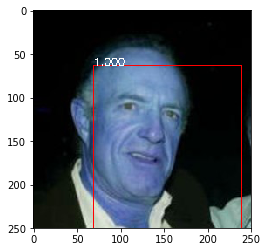

In [7]:
img = cv2.imread(human_files[3])
boxes, boxes_c = mtcnn_detector.detect_pnet(img)
boxes, boxes_c = mtcnn_detector.detect_rnet(img, boxes_c)
boxes, boxes_c = mtcnn_detector.detect_onet(img, boxes_c)
font = cv2.FONT_HERSHEY_SIMPLEX

if boxes_c is None:
    print('No faces are detected.')
    
else:

    print('Number of faces detected:', len(boxes_c))

    # get bounding box for each detected face
    for (x,y,w,h,p) in boxes_c:
        # add bounding box to color image
        cv2.rectangle(img,(int(x),int(y)),(int(x)+int(w),int(y)+int(h)),(255,0,0),1)
        cv2.putText(img, '%.3f' % p, (int(x), int(y)), font, 0.4, (255, 255, 255), 1)

    # convert BGR image to RGB for plotting
    #cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # display the image, along with bounding box
    plt.imshow(img)
    plt.show()
    
    
    

#### 3. Program the detector

In [8]:
def face_detectorCNN(img_path):
    img = cv2.imread(img_path)
    boxes, boxes_c = mtcnn_detector.detect_pnet(img)
    boxes, boxes_c = mtcnn_detector.detect_rnet(img, boxes_c)
    boxes, boxes_c = mtcnn_detector.detect_onet(img, boxes_c)
    if boxes_c is None:
            return False
    else: return True

#### 4.Test the performance 

In [9]:
human_detectCNN = list(map(face_detectorCNN, human_files_short))
dog_detectCNN = list(map(face_detectorCNN, dog_files_short))
print("The percentage of the first 100 images in human_files that have a detected human face:")
print(str(sum(human_detectCNN))+'%')
print("The percentage of the first 100 images in dog_files that have a detected human face:")
print(str(sum(dog_detectCNN))+'%')

The percentage of the first 100 images in human_files that have a detected human face:
100%
The percentage of the first 100 images in dog_files that have a detected human face:
6%


#### 5. Check the misclassified images

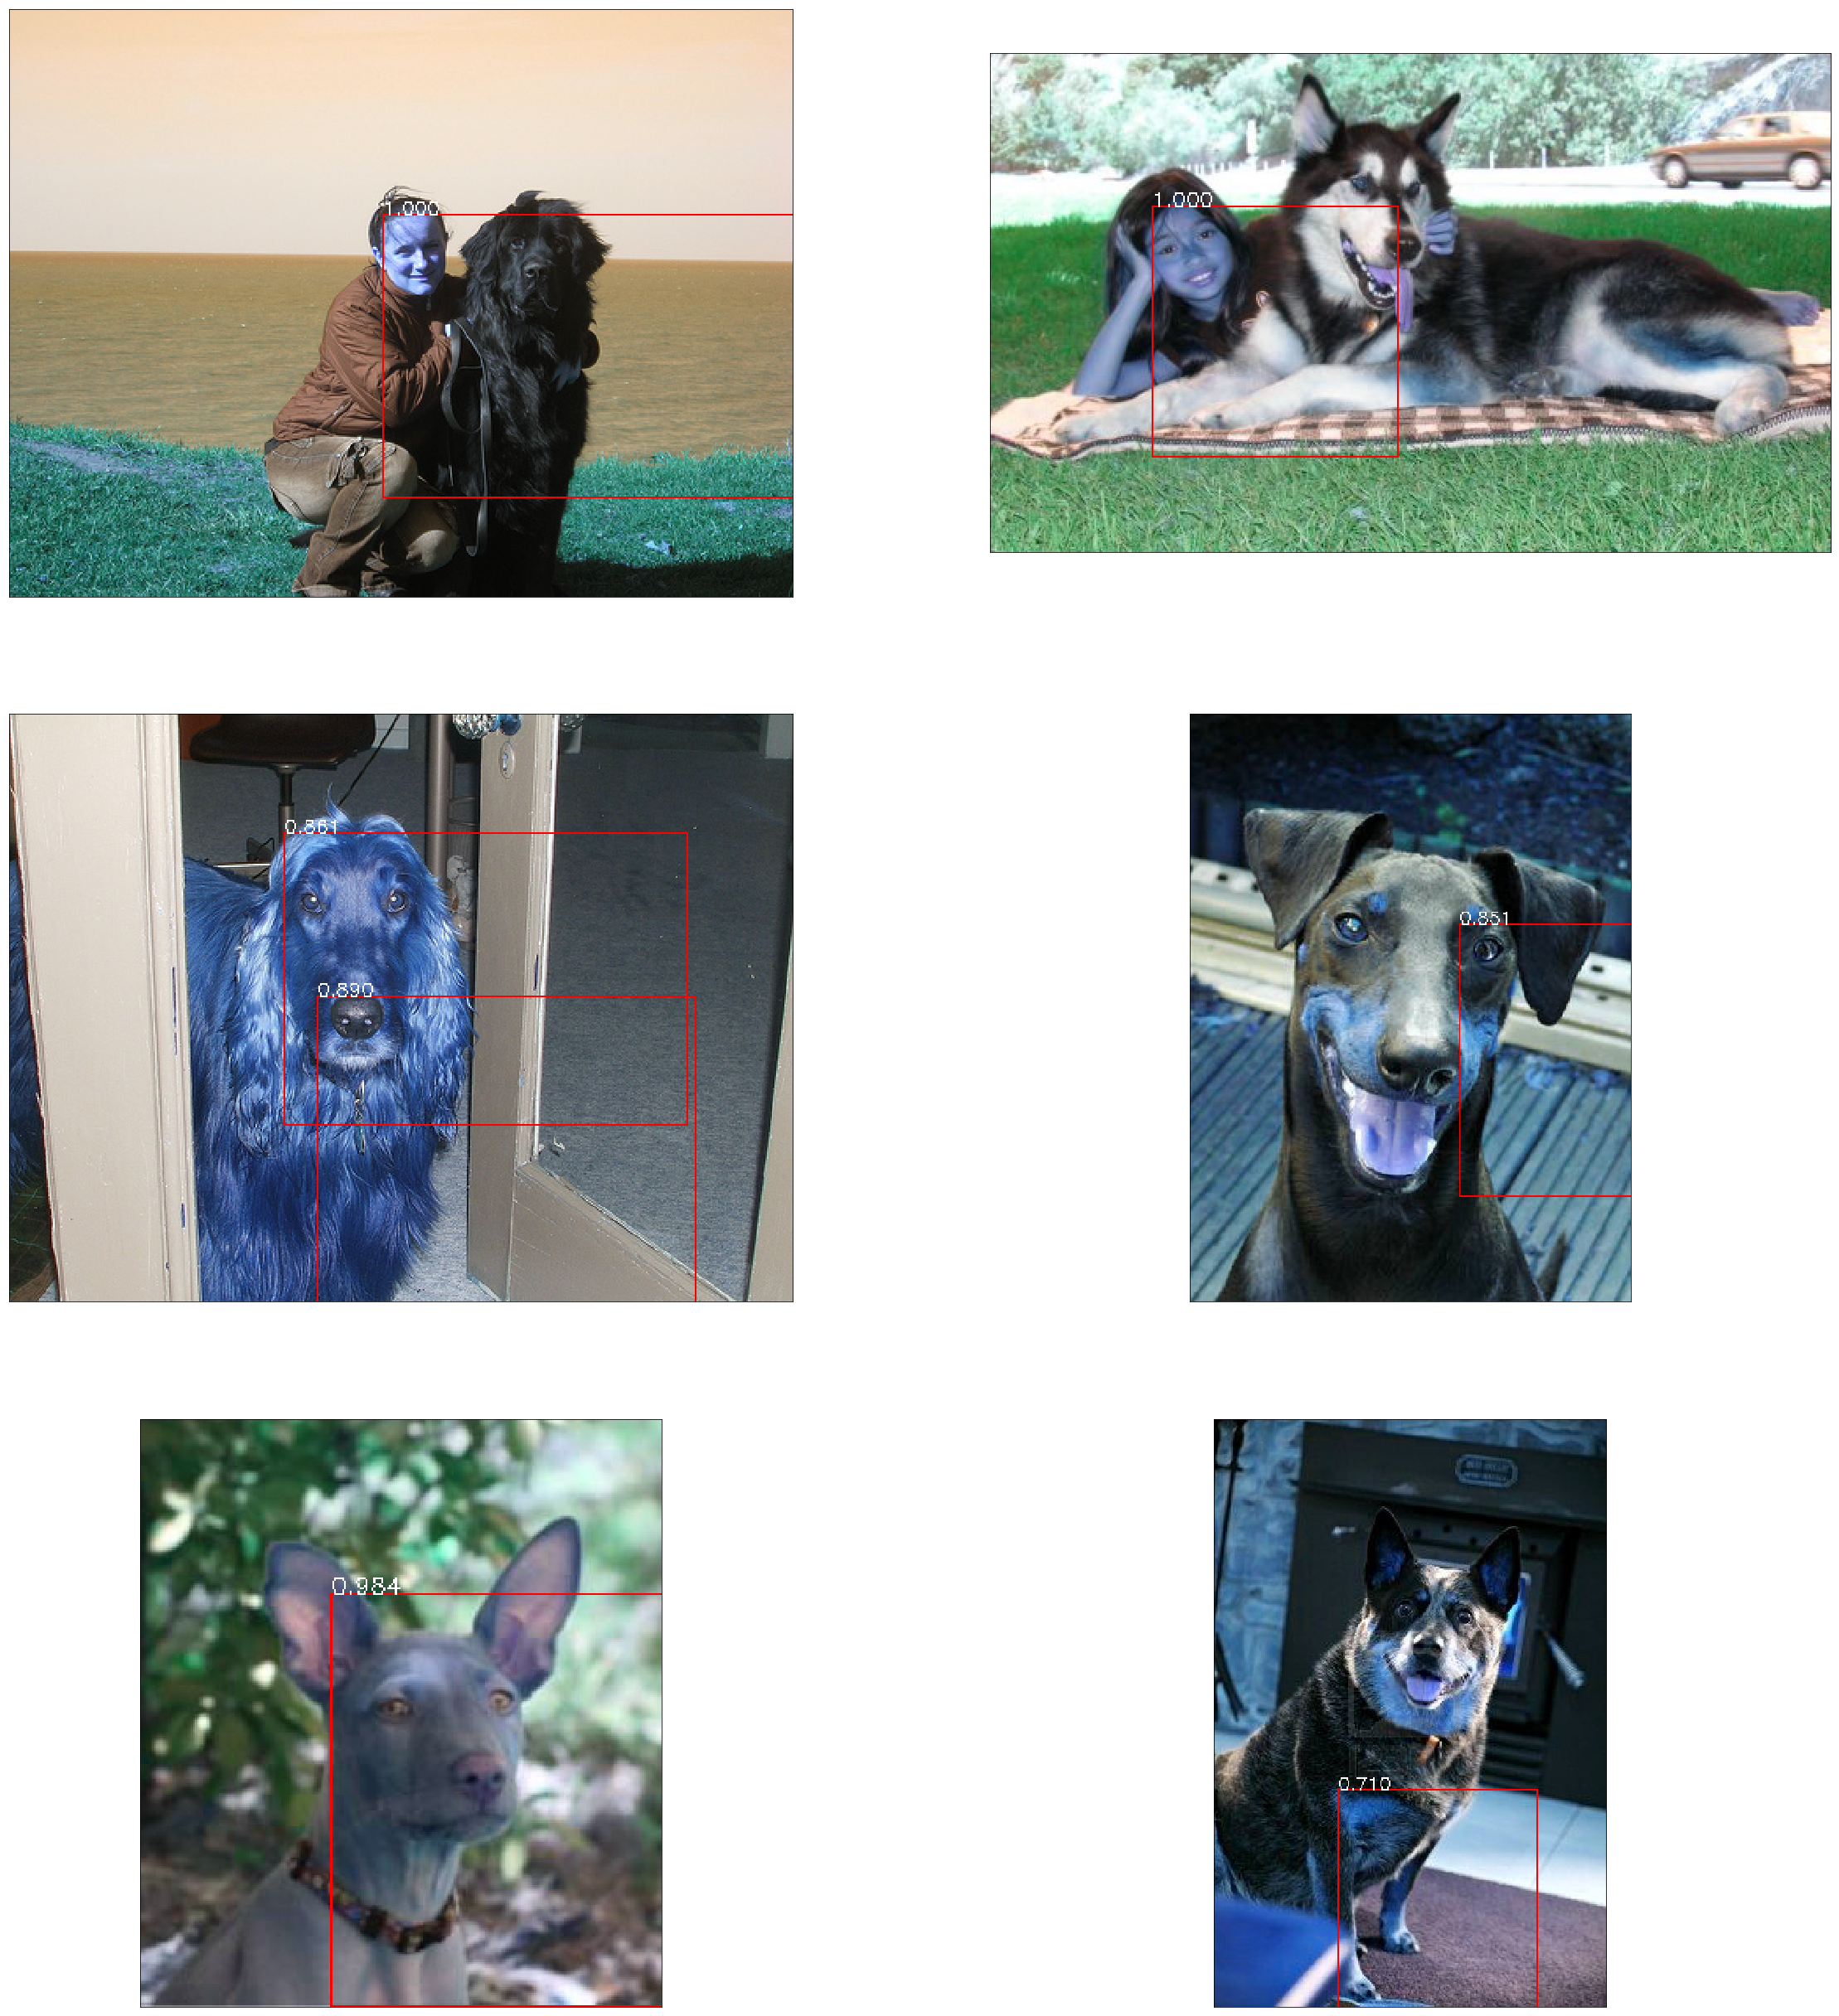

In [10]:
figure = plt.figure(figsize=(40, 60))
n=0
for i in range(len(dog_detectCNN)):
    if dog_detectCNN[i]:
        img = cv2.imread(dog_files_short[i])
        ax=figure.add_subplot(4, 2, n+1, xticks=[], yticks=[])
        boxes, boxes_c = mtcnn_detector.detect_pnet(img)
        boxes, boxes_c = mtcnn_detector.detect_rnet(img, boxes_c)
        boxes, boxes_c = mtcnn_detector.detect_onet(img, boxes_c)
        for (x,y,w,h,p) in boxes_c:
            # add bounding box to color image
            cv2.rectangle(img,(int(x),int(y)),(int(x)+int(w),int(y)+int(h)),(255,0,0),1)
            cv2.putText(img, '%.3f' % p, (int(x), int(y)), font, 0.4, (255, 255, 255), 1)
        ax.imshow(img)
        n+=1

#### 5. Modify the face detector by increase the threshold of detection and check the performance again

In [11]:
def face_detectorCNN1(img_path):
    img = cv2.imread(img_path)
    boxes, boxes_c = mtcnn_detector.detect_pnet(img)
    boxes, boxes_c = mtcnn_detector.detect_rnet(img, boxes_c)
    boxes, boxes_c = mtcnn_detector.detect_onet(img, boxes_c)
    if boxes_c is None:
            return False
    else: 
        flag = False
        for face in boxes_c:
            if face[4] >= 0.999:
                flag = True
                break
        return flag
    
# Test on the second 100 images
human_files_short1 = human_files[100:200]
dog_files_short1 = train_files[100:200]
human_detectCNN1 = list(map(face_detectorCNN1, human_files_short1))
dog_detectCNN1 = list(map(face_detectorCNN1, dog_files_short1))
print("The percentage of the second 100 images in human_files that have a detected human face:")
print(str(sum(human_detectCNN1))+'%')
print("The percentage of the second 100 images in dog_files that have a detected human face:")
print(str(sum(dog_detectCNN1))+'%')

The percentage of the second 100 images in human_files that have a detected human face:
100%
The percentage of the second 100 images in dog_files that have a detected human face:
6%


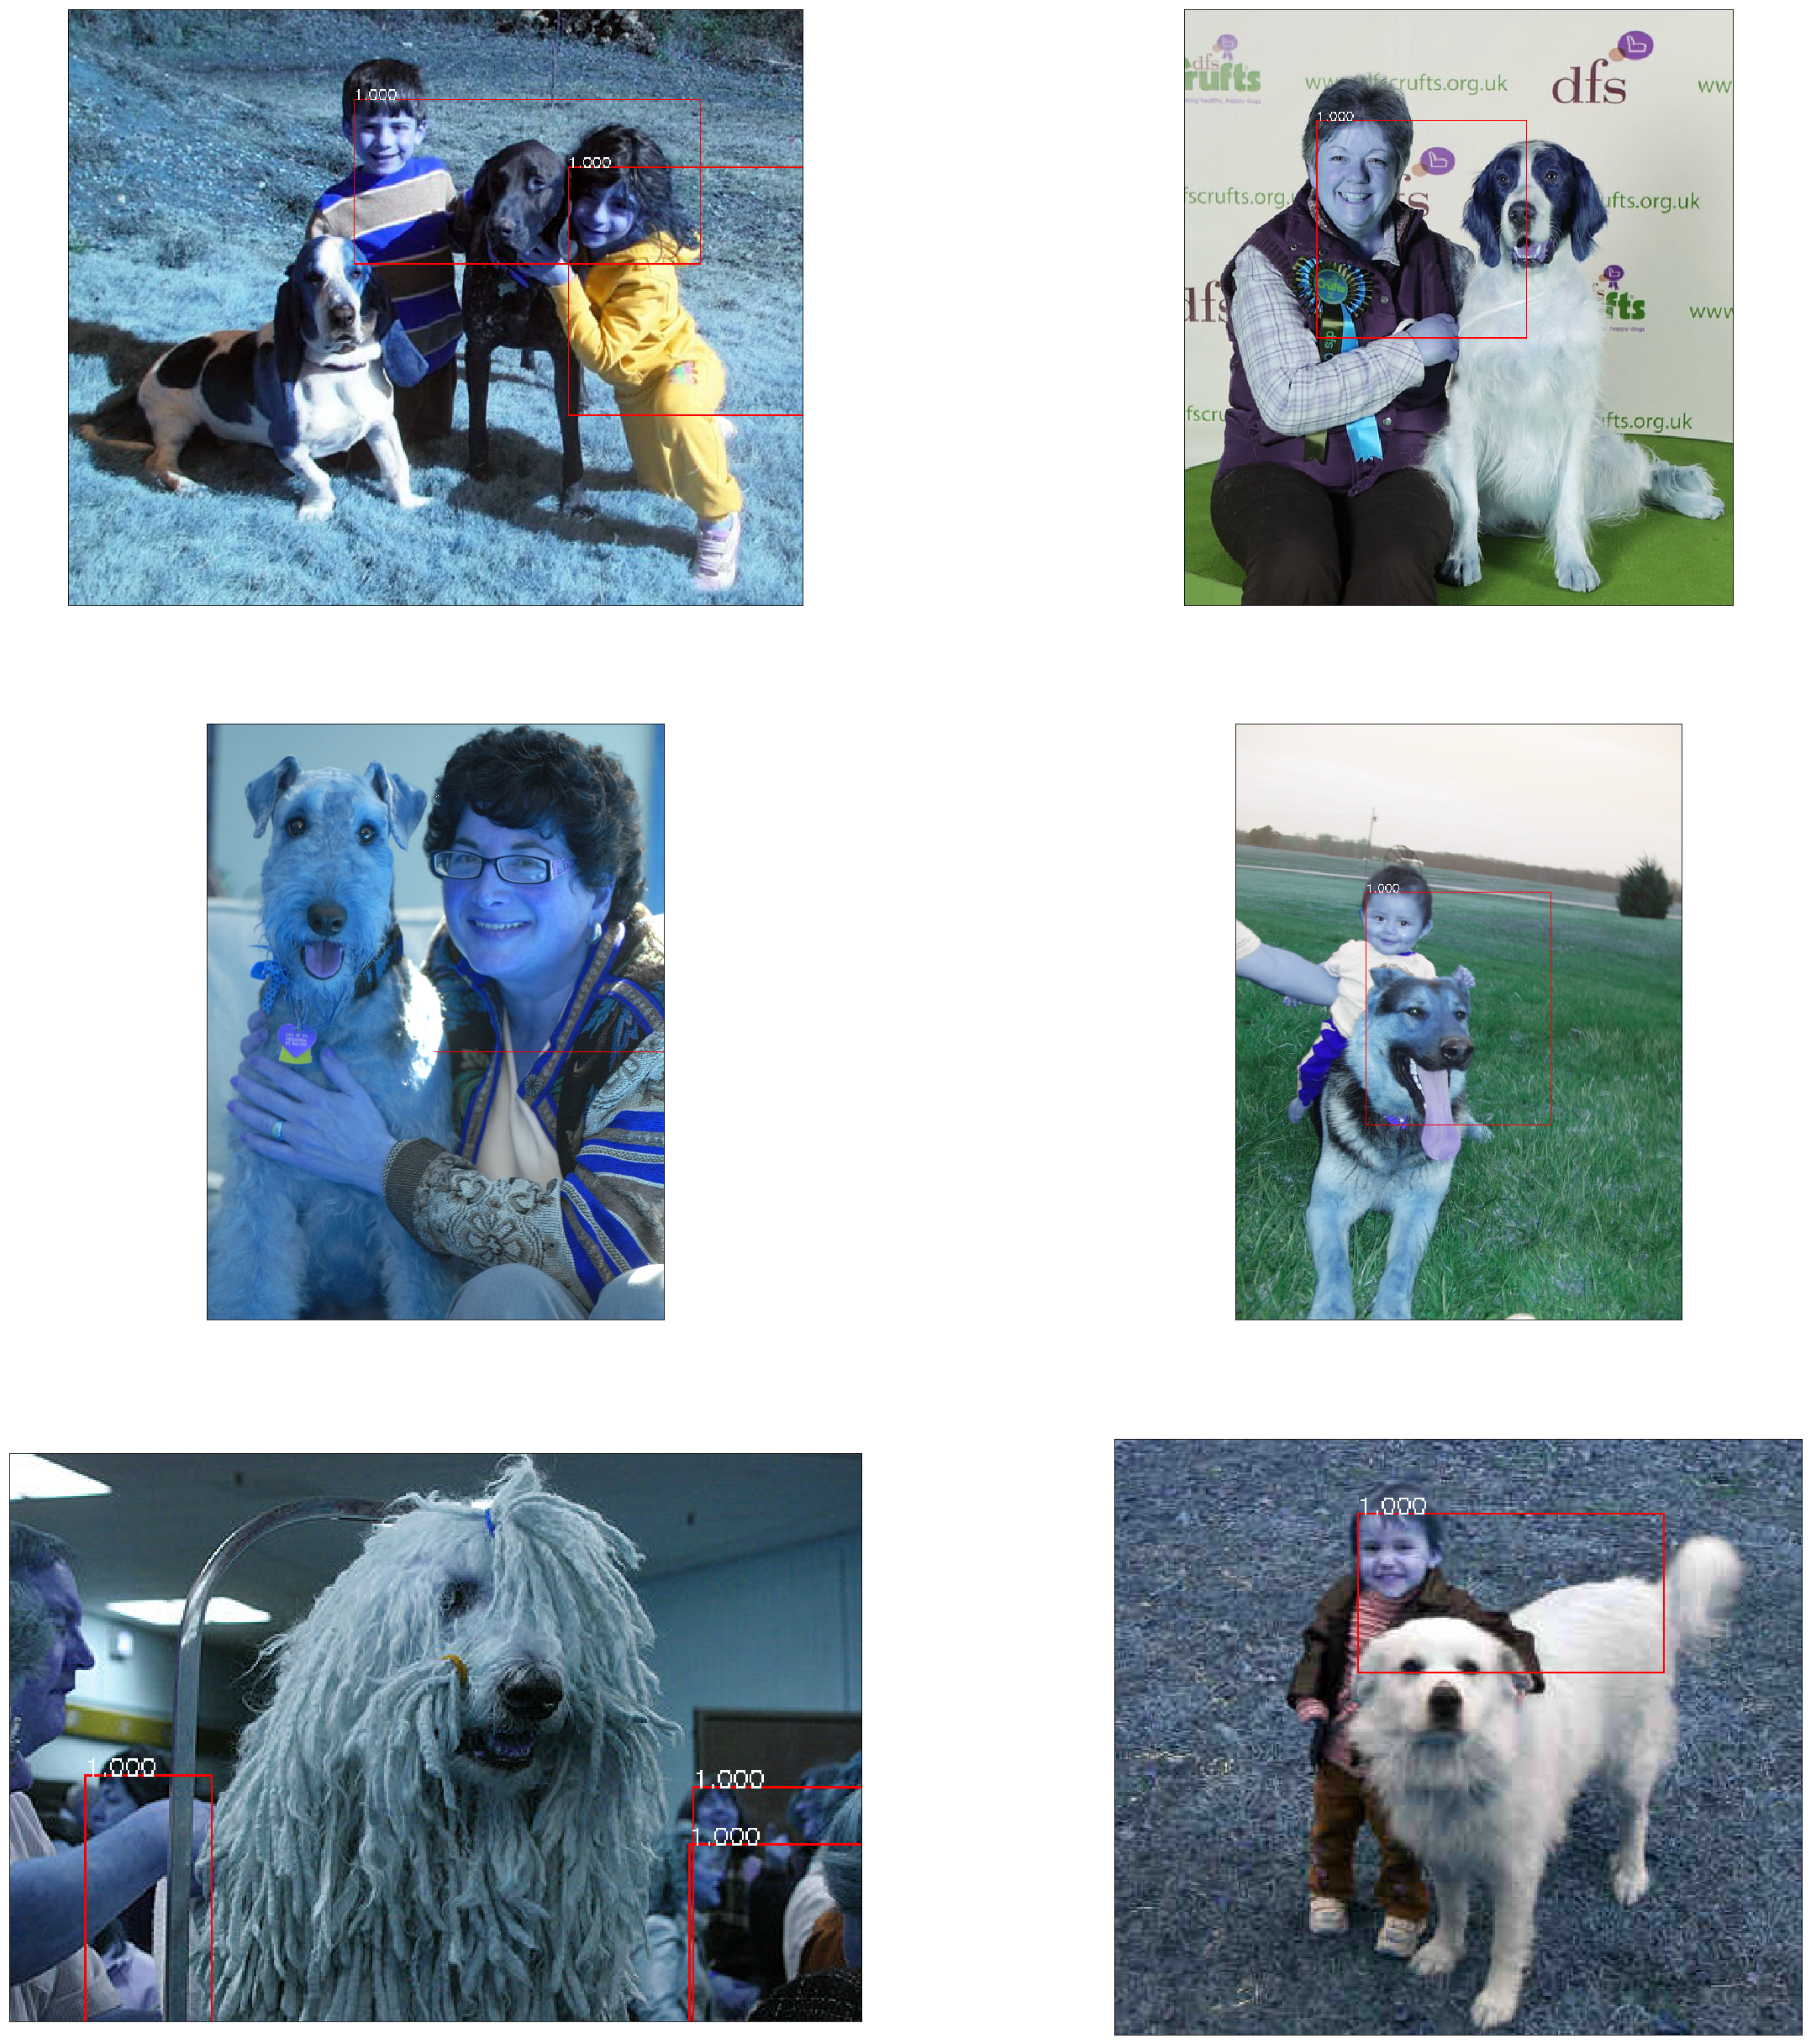

In [12]:
# check the misclassified images
figure = plt.figure(figsize=(40, 60))
n=0
for i in range(len(dog_detectCNN1)):
    if dog_detectCNN1[i]:
        img = cv2.imread(dog_files_short1[i])
        ax=figure.add_subplot(4, 2, n+1, xticks=[], yticks=[])
        boxes, boxes_c = mtcnn_detector.detect_pnet(img)
        boxes, boxes_c = mtcnn_detector.detect_rnet(img, boxes_c)
        boxes, boxes_c = mtcnn_detector.detect_onet(img, boxes_c)
        for (x,y,w,h,p) in boxes_c:
            # add bounding box to color image
            cv2.rectangle(img,(int(x),int(y)),(int(x)+int(w),int(y)+int(h)),(255,0,0),1)
            cv2.putText(img, '%.3f' % p, (int(x), int(y)), font, 0.4, (255, 255, 255), 1)
        ax.imshow(img)
        n+=1

#### 6. Conclusion

For the human_files all the images are correctly classified. For dog_files there are six pictures recognized as human images. A close check show that those images actually contain human faces, which are even not clearly present. Therefore, in this test the recall and precision of this detector should all be be 100% correct. It is a much better face detector than the previous one.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [13]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

/home/jin/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [14]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [15]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [16]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [17]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
human_detect = map(dog_detector, human_files_short)
dog_detect = map(dog_detector, dog_files_short)
print("The percentage of the first 100 images in human_files that have a detected dog:")
print(str(sum(human_detect))+'%')
print("The percentage of the first 100 images in dog_files that have a detected dog:")
print(str(sum(dog_detect))+'%')

The percentage of the first 100 images in human_files that have a detected dog:
2%
The percentage of the first 100 images in dog_files that have a detected dog:
100%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [18]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:04<00:00, 205.41it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

I would like to use the hinted architecture as shown above. I think it is a reasonable architecture. Firstly it starts with a 2D convolutional layer with a input shape that matches the shape of the input figure matrix. In this convolutional layer a small number of 16 filters is used, which will detect the most basic features contained in the dog images like lines and edges. Since those features are relatively low-level and simple, the 16 filters should provide sufficient variety for those features. The kernel_size is chosen to be 2x2, which remains the same for subsequent convolutional layers. Such a small receptive field of filters will force the CNN to concentrate on the small and detailed features. I think this is important for this task, since in many cases the differences between dog breeds are actually in small details like shape and style of their hair. Following the first convolutional layer is the max pooling layer with a kernel size 2x2, which reduces the dimension of the layer in both width and height by a factor of two. Such a reduction will also reduce the number of weights in a subsequent layer by a factor of 4 and thus can potentially reduce the risk of overfitting. Since the max pooling layer keeps only the highest activation in the receptive windows of each stride, the information from the previous vonvolutional layer can be considered condensed, which will facilitate the extracting of features at a higher level in the subsequent layer. 

By repeating such a consecutive series of a convulutional layer and a max pooling layer for 2 more times, the lateral dimensions of the CNN layer are gradually reduced to 27x27, which involve more condensed spatial information and higher level of abstraction. Correspondingly, we also get filters for features with increased complexity and abstraction. Meanwhile, the number of those features also increases stepwise with the increasing depth of the layers to provide sufficient variety. After the last max pooling layer, the we get a 27x27 mapping of 64 high-level features. For the first try, I think the depth of the present CNN is a reasonable value to start with. We can gradually increase the depth of the network afterwards and compare the training and testing loss as well as their accuracies timely to prevent the possible overfitting.

The information contained in the  is then summarized by a global average pooling into 64 float numbers, which are finally fed to a fully connected layer with 133 neurons corresponding to the 133 dog breeds. After passing the softmax activation function, the final outputs provide the predicted probability for each dog breed. 

During the training a dropout layer with a dropout rate of 0.3 has been added before the fully connected layer to reduce the overfitting.


In [3]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(133, activation='softmax'))


### TODO: Define your architecture.

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

### Compile the Model

In [23]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

/home/jin/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [26]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 1000

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)


model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets), epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.9480 - acc: 0.1151 - val_loss: 4.0661 - val_acc: 0.1006
Epoch 2/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.9427 - acc: 0.1174 - val_loss: 4.0020 - val_acc: 0.1054
Epoch 3/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.9426 - acc: 0.1105 - val_loss: 4.0326 - val_acc: 0.1090
Epoch 4/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.9374 - acc: 0.1136 - val_loss: 4.0607 - val_acc: 0.0958
Epoch 5/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.9183 - acc: 0.1193 - val_loss: 4.0181 - val_acc: 0.1269
Epoch 6/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.9301 - acc: 0.1166 - val_loss: 4.0700 - val_acc: 0.1114
Epoch 7/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.9109 - acc: 0.1199 - val_loss: 4.0108 - val_acc: 0.1281
E

Epoch 31/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.8493 - acc: 0.1228 - val_loss: 3.9328 - val_acc: 0.1317
Epoch 32/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.8584 - acc: 0.1272 - val_loss: 3.9377 - val_acc: 0.1293
Epoch 33/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.8572 - acc: 0.1311 - val_loss: 3.9610 - val_acc: 0.1234
Epoch 34/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.8364 - acc: 0.1326 - val_loss: 3.9832 - val_acc: 0.1234
Epoch 35/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.8461 - acc: 0.1293 - val_loss: 4.0049 - val_acc: 0.1126
Epoch 36/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.8539 - acc: 0.1274 - val_loss: 3.9545 - val_acc: 0.1365
Epoch 37/1000
6680/6680 [==============================] - 9s 1ms/step - loss: 3.8366 - acc: 0.1317 - val_loss: 4.0147 - val_acc: 0.1257
Epoch 38/1000
6680/6680 [================

Epoch 93/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.7260 - acc: 0.1446 - val_loss: 4.0088 - val_acc: 0.0994
Epoch 94/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.7282 - acc: 0.1391 - val_loss: 3.9117 - val_acc: 0.1365
Epoch 95/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.7392 - acc: 0.1476 - val_loss: 3.8859 - val_acc: 0.1305
Epoch 96/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.7233 - acc: 0.1497 - val_loss: 3.8697 - val_acc: 0.1389
Epoch 97/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.7204 - acc: 0.1454 - val_loss: 3.9069 - val_acc: 0.1341
Epoch 98/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.7306 - acc: 0.1430 - val_loss: 3.9043 - val_acc: 0.1293
Epoch 99/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.7357 - acc: 0.1430 - val_loss: 3.8865 - val_acc: 0.1281
Epoch 100/1000
6680/6680 [===============

Epoch 125/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6913 - acc: 0.1540 - val_loss: 3.8725 - val_acc: 0.1234
Epoch 126/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6925 - acc: 0.1518 - val_loss: 3.8753 - val_acc: 0.1198
Epoch 127/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6839 - acc: 0.1536 - val_loss: 3.8590 - val_acc: 0.1257
Epoch 128/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6833 - acc: 0.1588 - val_loss: 3.9346 - val_acc: 0.1174
Epoch 129/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6789 - acc: 0.1515 - val_loss: 3.9652 - val_acc: 0.1126
Epoch 130/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6969 - acc: 0.1430 - val_loss: 3.9696 - val_acc: 0.1090
Epoch 131/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.7104 - acc: 0.1431 - val_loss: 3.8570 - val_acc: 0.1222
Epoch 132/1000
6680/6680 [========

Epoch 157/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6703 - acc: 0.1560 - val_loss: 3.9256 - val_acc: 0.1293
Epoch 158/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6668 - acc: 0.1509 - val_loss: 3.8481 - val_acc: 0.1186
Epoch 159/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6744 - acc: 0.1611 - val_loss: 3.8985 - val_acc: 0.1150
Epoch 160/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6697 - acc: 0.1579 - val_loss: 4.0170 - val_acc: 0.1305
Epoch 161/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6779 - acc: 0.1539 - val_loss: 3.9536 - val_acc: 0.1066
Epoch 162/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6498 - acc: 0.1576 - val_loss: 3.9103 - val_acc: 0.1353
Epoch 163/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6588 - acc: 0.1463 - val_loss: 3.9149 - val_acc: 0.1138
Epoch 164/1000
6680/6680 [========

Epoch 189/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6642 - acc: 0.1546 - val_loss: 3.8349 - val_acc: 0.1353
Epoch 190/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6813 - acc: 0.1528 - val_loss: 3.9006 - val_acc: 0.1150
Epoch 191/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6683 - acc: 0.1546 - val_loss: 3.8326 - val_acc: 0.1305
Epoch 192/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6611 - acc: 0.1588 - val_loss: 3.8295 - val_acc: 0.1521
Epoch 193/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6665 - acc: 0.1575 - val_loss: 4.0842 - val_acc: 0.1174
Epoch 194/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6670 - acc: 0.1578 - val_loss: 3.9211 - val_acc: 0.1234
Epoch 195/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6656 - acc: 0.1579 - val_loss: 3.8660 - val_acc: 0.1198
Epoch 196/1000
6680/6680 [========

Epoch 220/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6721 - acc: 0.1530 - val_loss: 3.8280 - val_acc: 0.1389
Epoch 221/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6732 - acc: 0.1542 - val_loss: 3.9095 - val_acc: 0.1281
Epoch 222/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6825 - acc: 0.1575 - val_loss: 4.0223 - val_acc: 0.1317
Epoch 223/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6858 - acc: 0.1528 - val_loss: 3.8121 - val_acc: 0.1329
Epoch 224/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6758 - acc: 0.1545 - val_loss: 3.8996 - val_acc: 0.1102
Epoch 225/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6937 - acc: 0.1578 - val_loss: 3.8604 - val_acc: 0.1246
Epoch 226/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6761 - acc: 0.1567 - val_loss: 3.8686 - val_acc: 0.1377
Epoch 227/1000
6680/6680 [========

Epoch 252/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.7035 - acc: 0.1466 - val_loss: 3.7822 - val_acc: 0.1509
Epoch 253/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.7046 - acc: 0.1500 - val_loss: 3.8740 - val_acc: 0.1293
Epoch 254/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.7046 - acc: 0.1549 - val_loss: 3.8827 - val_acc: 0.1353
Epoch 255/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6907 - acc: 0.1524 - val_loss: 3.9503 - val_acc: 0.1126
Epoch 256/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6988 - acc: 0.1528 - val_loss: 3.9951 - val_acc: 0.0970
Epoch 257/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6984 - acc: 0.1485 - val_loss: 4.0107 - val_acc: 0.1269
Epoch 258/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.7002 - acc: 0.1551 - val_loss: 4.0150 - val_acc: 0.1126
Epoch 259/1000
6680/6680 [========

Epoch 284/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.7095 - acc: 0.1464 - val_loss: 3.8830 - val_acc: 0.1473
Epoch 285/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.7034 - acc: 0.1484 - val_loss: 4.0450 - val_acc: 0.1365
Epoch 286/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6924 - acc: 0.1504 - val_loss: 3.9246 - val_acc: 0.1210
Epoch 287/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6913 - acc: 0.1542 - val_loss: 4.0590 - val_acc: 0.0946
Epoch 288/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6830 - acc: 0.1497 - val_loss: 3.9230 - val_acc: 0.1413
Epoch 289/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.7029 - acc: 0.1493 - val_loss: 4.1237 - val_acc: 0.1317
Epoch 290/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6843 - acc: 0.1560 - val_loss: 3.8764 - val_acc: 0.1401
Epoch 291/1000
6680/6680 [========

Epoch 316/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6602 - acc: 0.1599 - val_loss: 3.8688 - val_acc: 0.1269
Epoch 317/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6628 - acc: 0.1609 - val_loss: 3.9007 - val_acc: 0.1162
Epoch 318/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6788 - acc: 0.1591 - val_loss: 3.8504 - val_acc: 0.1281
Epoch 319/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6686 - acc: 0.1618 - val_loss: 3.8844 - val_acc: 0.1377
Epoch 320/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6558 - acc: 0.1608 - val_loss: 3.8769 - val_acc: 0.1341
Epoch 321/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6615 - acc: 0.1609 - val_loss: 3.8792 - val_acc: 0.1222
Epoch 322/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6488 - acc: 0.1629 - val_loss: 3.9291 - val_acc: 0.1545
Epoch 323/1000
6680/6680 [========

Epoch 348/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6368 - acc: 0.1581 - val_loss: 3.8905 - val_acc: 0.1222
Epoch 349/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6446 - acc: 0.1585 - val_loss: 3.8780 - val_acc: 0.1425
Epoch 350/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6524 - acc: 0.1551 - val_loss: 3.9229 - val_acc: 0.1401
Epoch 351/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6603 - acc: 0.1611 - val_loss: 3.8635 - val_acc: 0.1341
Epoch 352/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6534 - acc: 0.1537 - val_loss: 3.8736 - val_acc: 0.1461
Epoch 353/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6397 - acc: 0.1633 - val_loss: 4.0381 - val_acc: 0.1329
Epoch 354/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6389 - acc: 0.1668 - val_loss: 4.0653 - val_acc: 0.1006
Epoch 355/1000
6680/6680 [========

Epoch 380/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6349 - acc: 0.1617 - val_loss: 3.8615 - val_acc: 0.1269
Epoch 381/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6258 - acc: 0.1657 - val_loss: 3.9321 - val_acc: 0.1353
Epoch 382/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6232 - acc: 0.1632 - val_loss: 4.1507 - val_acc: 0.0898
Epoch 383/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6441 - acc: 0.1618 - val_loss: 4.0764 - val_acc: 0.1317
Epoch 384/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6287 - acc: 0.1656 - val_loss: 3.9952 - val_acc: 0.1114
Epoch 385/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6186 - acc: 0.1710 - val_loss: 3.9867 - val_acc: 0.1102
Epoch 386/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6339 - acc: 0.1612 - val_loss: 4.0490 - val_acc: 0.0958
Epoch 387/1000
6680/6680 [========

Epoch 412/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6378 - acc: 0.1608 - val_loss: 4.0148 - val_acc: 0.1509
Epoch 413/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6408 - acc: 0.1609 - val_loss: 3.8906 - val_acc: 0.1329
Epoch 414/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6349 - acc: 0.1653 - val_loss: 3.9371 - val_acc: 0.1281
Epoch 415/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6179 - acc: 0.1686 - val_loss: 3.8899 - val_acc: 0.1293
Epoch 416/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6416 - acc: 0.1624 - val_loss: 4.1046 - val_acc: 0.1437
Epoch 417/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6424 - acc: 0.1588 - val_loss: 3.8773 - val_acc: 0.1425
Epoch 418/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6336 - acc: 0.1596 - val_loss: 3.9451 - val_acc: 0.1234
Epoch 419/1000
6680/6680 [========

Epoch 444/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6193 - acc: 0.1624 - val_loss: 3.8798 - val_acc: 0.1473
Epoch 445/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6444 - acc: 0.1660 - val_loss: 3.9979 - val_acc: 0.1234
Epoch 446/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6257 - acc: 0.1659 - val_loss: 3.9304 - val_acc: 0.1293
Epoch 447/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6383 - acc: 0.1672 - val_loss: 3.9304 - val_acc: 0.1353
Epoch 448/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6066 - acc: 0.1725 - val_loss: 4.0226 - val_acc: 0.1389
Epoch 449/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6291 - acc: 0.1651 - val_loss: 3.9348 - val_acc: 0.1222
Epoch 450/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6288 - acc: 0.1665 - val_loss: 3.9407 - val_acc: 0.1114
Epoch 451/1000
6680/6680 [========

Epoch 476/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6302 - acc: 0.1606 - val_loss: 4.3289 - val_acc: 0.1234
Epoch 477/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6523 - acc: 0.1615 - val_loss: 3.9105 - val_acc: 0.1293
Epoch 478/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6312 - acc: 0.1684 - val_loss: 3.9483 - val_acc: 0.1425
Epoch 479/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6357 - acc: 0.1633 - val_loss: 3.9886 - val_acc: 0.1401
Epoch 480/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6225 - acc: 0.1662 - val_loss: 4.2581 - val_acc: 0.1389
Epoch 481/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6453 - acc: 0.1641 - val_loss: 3.9115 - val_acc: 0.1234
Epoch 482/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6294 - acc: 0.1657 - val_loss: 4.0244 - val_acc: 0.1030
Epoch 483/1000
6680/6680 [========

Epoch 508/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6548 - acc: 0.1608 - val_loss: 4.0575 - val_acc: 0.0994
Epoch 509/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6422 - acc: 0.1576 - val_loss: 4.1462 - val_acc: 0.1413
Epoch 510/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6723 - acc: 0.1617 - val_loss: 3.9635 - val_acc: 0.1473
Epoch 511/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6621 - acc: 0.1555 - val_loss: 3.9778 - val_acc: 0.1210
Epoch 512/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6428 - acc: 0.1603 - val_loss: 4.0577 - val_acc: 0.1210
Epoch 513/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6676 - acc: 0.1582 - val_loss: 3.9170 - val_acc: 0.1449
Epoch 514/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6696 - acc: 0.1570 - val_loss: 3.9678 - val_acc: 0.1257
Epoch 515/1000
6680/6680 [========

Epoch 540/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6772 - acc: 0.1579 - val_loss: 3.9597 - val_acc: 0.1186
Epoch 541/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6751 - acc: 0.1677 - val_loss: 4.0617 - val_acc: 0.1138
Epoch 542/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6772 - acc: 0.1557 - val_loss: 4.1220 - val_acc: 0.0982
Epoch 543/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6702 - acc: 0.1578 - val_loss: 4.1386 - val_acc: 0.1222
Epoch 544/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6743 - acc: 0.1478 - val_loss: 3.9857 - val_acc: 0.1317
Epoch 545/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6736 - acc: 0.1645 - val_loss: 3.9049 - val_acc: 0.1461
Epoch 546/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6788 - acc: 0.1582 - val_loss: 4.1745 - val_acc: 0.1389
Epoch 547/1000
6680/6680 [========

Epoch 572/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6991 - acc: 0.1555 - val_loss: 4.0455 - val_acc: 0.1126
Epoch 573/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.7224 - acc: 0.1501 - val_loss: 4.0892 - val_acc: 0.0922
Epoch 574/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.7090 - acc: 0.1491 - val_loss: 4.0192 - val_acc: 0.1401
Epoch 575/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.6936 - acc: 0.1605 - val_loss: 3.9408 - val_acc: 0.1150
Epoch 576/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.7104 - acc: 0.1476 - val_loss: 4.0209 - val_acc: 0.1018
Epoch 577/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.7325 - acc: 0.1482 - val_loss: 4.0077 - val_acc: 0.0994
Epoch 578/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.7212 - acc: 0.1563 - val_loss: 3.9836 - val_acc: 0.1138
Epoch 579/1000
6680/6680 [========

Epoch 604/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.7691 - acc: 0.1427 - val_loss: 4.2097 - val_acc: 0.0946
Epoch 605/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.7688 - acc: 0.1430 - val_loss: 4.0009 - val_acc: 0.1210
Epoch 606/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.7758 - acc: 0.1488 - val_loss: 3.9996 - val_acc: 0.1066
Epoch 607/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.7786 - acc: 0.1451 - val_loss: 4.4954 - val_acc: 0.0970
Epoch 608/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.8098 - acc: 0.1431 - val_loss: 4.0682 - val_acc: 0.1162
Epoch 609/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.8116 - acc: 0.1401 - val_loss: 4.1651 - val_acc: 0.0886
Epoch 610/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.8208 - acc: 0.1376 - val_loss: 4.0585 - val_acc: 0.1162
Epoch 611/1000
6680/6680 [========

Epoch 636/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.8556 - acc: 0.1274 - val_loss: 4.1500 - val_acc: 0.1006
Epoch 637/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.8589 - acc: 0.1356 - val_loss: 4.0966 - val_acc: 0.0922
Epoch 638/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.8417 - acc: 0.1341 - val_loss: 4.1488 - val_acc: 0.0790
Epoch 639/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.8476 - acc: 0.1332 - val_loss: 4.2329 - val_acc: 0.0922
Epoch 640/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.8548 - acc: 0.1335 - val_loss: 4.2096 - val_acc: 0.0850
Epoch 641/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.8680 - acc: 0.1383 - val_loss: 4.1786 - val_acc: 0.0958
Epoch 642/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.8793 - acc: 0.1280 - val_loss: 4.0470 - val_acc: 0.1102
Epoch 643/1000
6680/6680 [========

Epoch 668/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.9606 - acc: 0.1310 - val_loss: 4.1939 - val_acc: 0.0850
Epoch 669/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.9803 - acc: 0.1225 - val_loss: 4.2197 - val_acc: 0.0754
Epoch 670/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.9677 - acc: 0.1237 - val_loss: 4.4054 - val_acc: 0.0587
Epoch 671/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.9776 - acc: 0.1253 - val_loss: 4.1293 - val_acc: 0.0958
Epoch 672/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.9885 - acc: 0.1180 - val_loss: 4.1276 - val_acc: 0.1222
Epoch 673/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 3.9627 - acc: 0.1201 - val_loss: 4.1584 - val_acc: 0.1078
Epoch 674/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.0016 - acc: 0.1225 - val_loss: 4.1517 - val_acc: 0.1054
Epoch 675/1000
6680/6680 [========

Epoch 700/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.1970 - acc: 0.0943 - val_loss: 4.2999 - val_acc: 0.0683
Epoch 701/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.1976 - acc: 0.1006 - val_loss: 4.6017 - val_acc: 0.0862
Epoch 702/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.2201 - acc: 0.0957 - val_loss: 4.2149 - val_acc: 0.0934
Epoch 703/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.2298 - acc: 0.0958 - val_loss: 4.3864 - val_acc: 0.0826
Epoch 704/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.2198 - acc: 0.1007 - val_loss: 4.5844 - val_acc: 0.0958
Epoch 705/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.2694 - acc: 0.0895 - val_loss: 4.1500 - val_acc: 0.0982
Epoch 706/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.2555 - acc: 0.0930 - val_loss: 4.4616 - val_acc: 0.0826
Epoch 707/1000
6680/6680 [========

Epoch 732/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4699 - acc: 0.0671 - val_loss: 4.4231 - val_acc: 0.0647
Epoch 733/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4357 - acc: 0.0657 - val_loss: 4.5221 - val_acc: 0.0383
Epoch 734/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4315 - acc: 0.0726 - val_loss: 4.4260 - val_acc: 0.0551
Epoch 735/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4540 - acc: 0.0657 - val_loss: 4.4423 - val_acc: 0.0467
Epoch 736/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4735 - acc: 0.0650 - val_loss: 4.5705 - val_acc: 0.0731
Epoch 737/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4700 - acc: 0.0656 - val_loss: 4.4493 - val_acc: 0.0491
Epoch 738/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4771 - acc: 0.0641 - val_loss: 4.5595 - val_acc: 0.0359
Epoch 739/1000
6680/6680 [========

Epoch 764/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4473 - acc: 0.0593 - val_loss: 4.7209 - val_acc: 0.0719
Epoch 765/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4632 - acc: 0.0609 - val_loss: 4.4423 - val_acc: 0.0551
Epoch 766/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4436 - acc: 0.0674 - val_loss: 4.4365 - val_acc: 0.0563
Epoch 767/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4584 - acc: 0.0602 - val_loss: 4.4420 - val_acc: 0.0719
Epoch 768/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4450 - acc: 0.0648 - val_loss: 4.4755 - val_acc: 0.0479
Epoch 769/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4714 - acc: 0.0632 - val_loss: 4.9425 - val_acc: 0.0335
Epoch 770/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4830 - acc: 0.0632 - val_loss: 4.6208 - val_acc: 0.0491
Epoch 771/1000
6680/6680 [========

Epoch 796/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4316 - acc: 0.0639 - val_loss: 4.5886 - val_acc: 0.0599
Epoch 797/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4399 - acc: 0.0651 - val_loss: 4.4748 - val_acc: 0.0695
Epoch 798/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4417 - acc: 0.0596 - val_loss: 4.4930 - val_acc: 0.0659
Epoch 799/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4338 - acc: 0.0657 - val_loss: 4.4461 - val_acc: 0.0587
Epoch 800/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4470 - acc: 0.0648 - val_loss: 4.5347 - val_acc: 0.0467
Epoch 801/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4457 - acc: 0.0621 - val_loss: 4.5567 - val_acc: 0.0491
Epoch 802/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4475 - acc: 0.0693 - val_loss: 4.6876 - val_acc: 0.0754
Epoch 803/1000
6680/6680 [========

Epoch 828/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4479 - acc: 0.0633 - val_loss: 4.4481 - val_acc: 0.0587
Epoch 829/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4351 - acc: 0.0632 - val_loss: 4.5332 - val_acc: 0.0575
Epoch 830/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4633 - acc: 0.0570 - val_loss: 4.7659 - val_acc: 0.0539
Epoch 831/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4451 - acc: 0.0623 - val_loss: 4.6837 - val_acc: 0.0467
Epoch 832/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4820 - acc: 0.0578 - val_loss: 4.6678 - val_acc: 0.0407
Epoch 833/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4744 - acc: 0.0600 - val_loss: 4.5687 - val_acc: 0.0335
Epoch 834/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4682 - acc: 0.0597 - val_loss: 4.4853 - val_acc: 0.0527
Epoch 835/1000
6680/6680 [========

Epoch 860/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4187 - acc: 0.0632 - val_loss: 4.4524 - val_acc: 0.0778
Epoch 861/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4118 - acc: 0.0642 - val_loss: 4.7307 - val_acc: 0.0611
Epoch 862/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4448 - acc: 0.0626 - val_loss: 4.5436 - val_acc: 0.0431
Epoch 863/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4525 - acc: 0.0633 - val_loss: 4.5591 - val_acc: 0.0371
Epoch 864/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4300 - acc: 0.0603 - val_loss: 4.5136 - val_acc: 0.0359
Epoch 865/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4221 - acc: 0.0638 - val_loss: 4.7184 - val_acc: 0.0599
Epoch 866/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4414 - acc: 0.0678 - val_loss: 4.5184 - val_acc: 0.0431
Epoch 867/1000
6680/6680 [========

Epoch 892/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4017 - acc: 0.0680 - val_loss: 4.4486 - val_acc: 0.0503
Epoch 893/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4089 - acc: 0.0666 - val_loss: 4.5253 - val_acc: 0.0371
Epoch 894/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4046 - acc: 0.0633 - val_loss: 4.4140 - val_acc: 0.0611
Epoch 895/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4255 - acc: 0.0650 - val_loss: 4.4376 - val_acc: 0.0539
Epoch 896/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4171 - acc: 0.0642 - val_loss: 4.4790 - val_acc: 0.0455
Epoch 897/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4079 - acc: 0.0620 - val_loss: 4.4930 - val_acc: 0.0599
Epoch 898/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4331 - acc: 0.0657 - val_loss: 5.1473 - val_acc: 0.0719
Epoch 899/1000
6680/6680 [========

Epoch 924/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4199 - acc: 0.0665 - val_loss: 4.4700 - val_acc: 0.0491
Epoch 925/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4299 - acc: 0.0642 - val_loss: 4.5209 - val_acc: 0.0527
Epoch 926/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4015 - acc: 0.0681 - val_loss: 4.8091 - val_acc: 0.0683
Epoch 927/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4026 - acc: 0.0710 - val_loss: 4.7106 - val_acc: 0.0359
Epoch 928/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4056 - acc: 0.0633 - val_loss: 4.4770 - val_acc: 0.0731
Epoch 929/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4129 - acc: 0.0647 - val_loss: 4.4587 - val_acc: 0.0647
Epoch 930/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4127 - acc: 0.0614 - val_loss: 4.6151 - val_acc: 0.0731
Epoch 931/1000
6680/6680 [========

Epoch 956/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4700 - acc: 0.0608 - val_loss: 4.5386 - val_acc: 0.0503
Epoch 957/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4667 - acc: 0.0606 - val_loss: 4.5380 - val_acc: 0.0431
Epoch 958/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4325 - acc: 0.0618 - val_loss: 4.7760 - val_acc: 0.0204
Epoch 959/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4558 - acc: 0.0530 - val_loss: 4.4426 - val_acc: 0.0695
Epoch 960/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4515 - acc: 0.0602 - val_loss: 4.4678 - val_acc: 0.0635
Epoch 961/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4827 - acc: 0.0573 - val_loss: 4.4711 - val_acc: 0.0515
Epoch 962/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4277 - acc: 0.0582 - val_loss: 4.5139 - val_acc: 0.0491
Epoch 963/1000
6680/6680 [========

Epoch 988/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4781 - acc: 0.0630 - val_loss: 4.4387 - val_acc: 0.0647
Epoch 989/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4537 - acc: 0.0602 - val_loss: 4.4850 - val_acc: 0.0575
Epoch 990/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4703 - acc: 0.0587 - val_loss: 4.5255 - val_acc: 0.0467
Epoch 991/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4739 - acc: 0.0590 - val_loss: 4.4930 - val_acc: 0.0539
Epoch 992/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4847 - acc: 0.0617 - val_loss: 4.5007 - val_acc: 0.0503
Epoch 993/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4448 - acc: 0.0591 - val_loss: 4.4290 - val_acc: 0.0599
Epoch 994/1000
6680/6680 [==============================] - 8s 1ms/step - loss: 4.4387 - acc: 0.0618 - val_loss: 4.7002 - val_acc: 0.0299
Epoch 995/1000
6680/6680 [========

### Load the Model with the Best Validation Loss

In [39]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [41]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 13.9952%


### Use the suggested model and trainging data augmentation
#### 1. Generate 4 sets of augmented images for the training set.

In [21]:
from glob import glob
import os

folders = glob('dogImages/train/*')
dogImages = []
for folder in folders:
    images = glob(folder+'/*')
    for image in images:
        dogImages.append([folder,image])

if not os.path.exists('augmentation'):
    os.mkdir('augmentation')    
    os.system('cp -r dogImages/train augmentation/train')




In [29]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from threading import Thread
from multiprocessing import Process
from queue import Queue, Empty
from time import sleep
from tqdm import tqdm

counter = []
def process_images(queue):
    global counter
    while True:
        try:
            folder, dog_image = queue.get(block=False)
        except Empty:
            break
        else:
            datagen = ImageDataGenerator(
            shear_range=0.2,           
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest')
            img = load_img(dog_image)
            x = img_to_array(img)
            x = x.reshape((1,)+x.shape)
            i = 0
            for batch in datagen.flow(x, batch_size=1,save_to_dir='augmentation/train/'+folder.split('/')[-1], 
                                      save_prefix='aug', save_format='jpeg'):
                i+=1
                if i > 4:
                    break
            counter.append(1)
                    

def progress():
    global counter
    perc_old = 0 
    for i in tqdm(range(6680)):
        while i > len(counter):
            pass

                   

aug_round = 4  # To generate 4 augmented figures for each figure
images_total = (aug_round+1)*6680

aug_num=sum([len(files) for r, d, files in os.walk("augmentation")])
print(aug_num)
if aug_num!= images_total:
    if aug_num != 6680:
        os.system('rm -r augmentation/train')
        os.system('cp -r dogImages/train augmentation/')
    n_ths = 16
    queue = Queue()
    for item in dogImages:
        queue.put(item)
    ths = [Thread(target=process_images, args=(queue,)) for i in range(n_ths)]
    for th in ths:
        th.start()
    ths_prog = Thread(target=progress, args=())
    ths_prog.setDaemon(True)
    ths_prog.start()
    for th in ths:
        th.join()
    ths_prog.join()




39629


100%|██████████| 6680/6680 [08:14<00:00, 13.51it/s]


#### 2. Feed the data with augmentation into a generator

In [10]:
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1./255)
train_generator = train_gen.flow_from_directory('augmentation/train', target_size=(224, 224), batch_size=20)

Found 39635 images belonging to 133 classes.


#### 3. Create a copy of the previous model and train the model with the augmented data set

In [43]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model2 = Sequential()
model2.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224,224,3)))
model2.add(MaxPooling2D(pool_size=2))
model2.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=2))
model2.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=2))
model2.add(GlobalAveragePooling2D())
model2.add(Dropout(0.3))
model2.add(Dense(133, activation='softmax'))


### TODO: Define your architecture.

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 64)                0         
__________

/home/jin/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


In [12]:
from keras.callbacks import ModelCheckpoint  
model2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer2 = ModelCheckpoint(filepath='saved_models/weights2.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)
model2.fit_generator(train_generator, steps_per_epoch=6680*5//20, epochs = 200, 
                     validation_data=(valid_tensors, valid_targets),
                      callbacks=[checkpointer2], verbose=1)

Epoch 1/200
1982/1670 [===================================] - 206s 104ms/step - loss: 4.7538 - acc: 0.0210 - val_loss: 4.7825 - val_acc: 0.0180
Epoch 2/200
1982/1670 [===================================] - 190s 96ms/step - loss: 4.6457 - acc: 0.0325 - val_loss: 4.7288 - val_acc: 0.0251
Epoch 3/200
1982/1670 [===================================] - 191s 96ms/step - loss: 4.5638 - acc: 0.0451 - val_loss: 4.5989 - val_acc: 0.0395
Epoch 4/200
1982/1670 [===================================] - 191s 96ms/step - loss: 4.4486 - acc: 0.0569 - val_loss: 4.5037 - val_acc: 0.0515
Epoch 5/200
1982/1670 [===================================] - 191s 96ms/step - loss: 4.3536 - acc: 0.0574 - val_loss: 4.4147 - val_acc: 0.0515
Epoch 6/200
1982/1670 [===================================] - 190s 96ms/step - loss: 4.2886 - acc: 0.0705 - val_loss: 4.3575 - val_acc: 0.0587
Epoch 7/200
1982/1670 [===================================] - 190s 96ms/step - loss: 4.2404 - acc: 0.0785 - val_loss: 4.3179 - val_acc: 0.064

Epoch 26/200
1982/1670 [===================================] - 190s 96ms/step - loss: 3.8124 - acc: 0.1356 - val_loss: 3.9861 - val_acc: 0.1222
Epoch 27/200
1982/1670 [===================================] - 190s 96ms/step - loss: 3.7798 - acc: 0.1411 - val_loss: 3.9589 - val_acc: 0.1305
Epoch 28/200
1982/1670 [===================================] - 190s 96ms/step - loss: 3.7799 - acc: 0.1429 - val_loss: 3.9195 - val_acc: 0.1126
Epoch 29/200
1982/1670 [===================================] - 190s 96ms/step - loss: 3.7555 - acc: 0.1399 - val_loss: 3.8885 - val_acc: 0.1281
Epoch 30/200
1982/1670 [===================================] - 190s 96ms/step - loss: 3.7977 - acc: 0.1396 - val_loss: 3.9637 - val_acc: 0.1102
Epoch 31/200
1982/1670 [===================================] - 190s 96ms/step - loss: 3.8071 - acc: 0.1351 - val_loss: 3.8563 - val_acc: 0.1377
Epoch 32/200
1982/1670 [===================================] - 190s 96ms/step - loss: 3.7537 - acc: 0.1400 - val_loss: 3.9015 - val_acc:

Epoch 85/200
1982/1670 [===================================] - 189s 96ms/step - loss: 3.6750 - acc: 0.1540 - val_loss: 3.7630 - val_acc: 0.1533
Epoch 86/200
1982/1670 [===================================] - 188s 95ms/step - loss: 3.6866 - acc: 0.1522 - val_loss: 3.9416 - val_acc: 0.1509
Epoch 87/200
1982/1670 [===================================] - 189s 95ms/step - loss: 3.7216 - acc: 0.1497 - val_loss: 3.7971 - val_acc: 0.1713
Epoch 88/200
1982/1670 [===================================] - 189s 95ms/step - loss: 3.7600 - acc: 0.1446 - val_loss: 3.8492 - val_acc: 0.1461
Epoch 89/200
1982/1670 [===================================] - 189s 95ms/step - loss: 3.7746 - acc: 0.1475 - val_loss: 3.9393 - val_acc: 0.1509
Epoch 90/200
1982/1670 [===================================] - 189s 95ms/step - loss: 3.7497 - acc: 0.1499 - val_loss: 3.9131 - val_acc: 0.1413
Epoch 91/200
1982/1670 [===================================] - 189s 95ms/step - loss: 3.7813 - acc: 0.1357 - val_loss: 3.8759 - val_acc:

1982/1670 [===================================] - 189s 95ms/step - loss: 4.2745 - acc: 0.0883 - val_loss: 4.2499 - val_acc: 0.0862
Epoch 117/200
1982/1670 [===================================] - 189s 95ms/step - loss: 4.3102 - acc: 0.0807 - val_loss: 4.3229 - val_acc: 0.0719
Epoch 118/200
1982/1670 [===================================] - 189s 95ms/step - loss: 4.3256 - acc: 0.0754 - val_loss: 4.2277 - val_acc: 0.0982
Epoch 119/200
1982/1670 [===================================] - 189s 95ms/step - loss: 4.3481 - acc: 0.0769 - val_loss: 4.2335 - val_acc: 0.0982
Epoch 120/200
1982/1670 [===================================] - 189s 95ms/step - loss: 4.3539 - acc: 0.0792 - val_loss: 4.8007 - val_acc: 0.0814
Epoch 121/200
1982/1670 [===================================] - 189s 95ms/step - loss: 4.3362 - acc: 0.0752 - val_loss: 4.2583 - val_acc: 0.0802
Epoch 122/200
1982/1670 [===================================] - 189s 95ms/step - loss: 4.4041 - acc: 0.0715 - val_loss: 4.3601 - val_acc: 0.0671

1982/1670 [===================================] - 189s 96ms/step - loss: 4.5497 - acc: 0.0524 - val_loss: 4.5517 - val_acc: 0.0671
Epoch 179/200
1982/1670 [===================================] - 188s 95ms/step - loss: 4.6075 - acc: 0.0430 - val_loss: 4.6008 - val_acc: 0.0491
Epoch 180/200
1982/1670 [===================================] - 189s 95ms/step - loss: 4.5829 - acc: 0.0461 - val_loss: 4.5877 - val_acc: 0.0395
Epoch 181/200
1982/1670 [===================================] - 189s 95ms/step - loss: 4.5918 - acc: 0.0431 - val_loss: 4.5088 - val_acc: 0.0383
Epoch 182/200
1982/1670 [===================================] - 189s 95ms/step - loss: 4.5911 - acc: 0.0489 - val_loss: 5.1331 - val_acc: 0.0407
Epoch 183/200
1982/1670 [===================================] - 189s 95ms/step - loss: 4.6351 - acc: 0.0440 - val_loss: 4.4894 - val_acc: 0.0563
Epoch 184/200
1982/1670 [===================================] - 189s 95ms/step - loss: 4.6237 - acc: 0.0456 - val_loss: 4.8209 - val_acc: 0.0180

#### 4. Test the model

In [15]:
model2.load_weights('saved_models/weights2.best.from_scratch.hdf5')
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model2.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 15.3110%


It can be seen the data augmentation enhanced the test accuracy compared to the previous case.

---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [22]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [23]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
###
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [6]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [10]:
from keras.callbacks import ModelCheckpoint  
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=200, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/200
6680/6680 [==============================] - 1s 121us/step - loss: 6.7198 - acc: 0.5751 - val_loss: 7.6889 - val_acc: 0.4575
Epoch 2/200
6680/6680 [==============================] - 1s 119us/step - loss: 6.6189 - acc: 0.5810 - val_loss: 7.6096 - val_acc: 0.4575
Epoch 3/200
6680/6680 [==============================] - 1s 120us/step - loss: 6.5518 - acc: 0.5858 - val_loss: 7.5821 - val_acc: 0.4599
Epoch 4/200
6680/6680 [==============================] - 1s 118us/step - loss: 6.3696 - acc: 0.5937 - val_loss: 7.2740 - val_acc: 0.4731
Epoch 5/200
6680/6680 [==============================] - 1s 119us/step - loss: 6.2123 - acc: 0.6033 - val_loss: 7.2745 - val_acc: 0.4766
Epoch 6/200
6680/6680 [==============================] - 1s 127us/step - loss: 6.1735 - acc: 0.6111 - val_loss: 7.2153 - val_acc: 0.4683
Epoch 7/200
6680/6680 [==============================] - 1s 119us/step - loss: 6.1367 - acc: 0.6130 - val_loss: 7.2395 - val_acc: 0

Epoch 59/200
6680/6680 [==============================] - 1s 120us/step - loss: 4.4560 - acc: 0.7201 - val_loss: 6.0853 - val_acc: 0.5665
Epoch 60/200
6680/6680 [==============================] - 1s 121us/step - loss: 4.4058 - acc: 0.7229 - val_loss: 6.0245 - val_acc: 0.5605
Epoch 61/200
6680/6680 [==============================] - 1s 125us/step - loss: 4.3970 - acc: 0.7251 - val_loss: 6.0162 - val_acc: 0.5581
Epoch 62/200
6680/6680 [==============================] - 1s 109us/step - loss: 4.3893 - acc: 0.7256 - val_loss: 5.9934 - val_acc: 0.5641
Epoch 63/200
6680/6680 [==============================] - 1s 113us/step - loss: 4.3836 - acc: 0.7266 - val_loss: 6.0271 - val_acc: 0.5617
Epoch 64/200
6680/6680 [==============================] - 1s 114us/step - loss: 4.3789 - acc: 0.7266 - val_loss: 6.0614 - val_acc: 0.5593
Epoch 65/200
6680/6680 [==============================] - 1s 107us/step - loss: 4.3790 - acc: 0.7269 - val_loss: 6.0197 - val_acc: 0.5605
Epoch 66/200
6680/6680 [==========

Epoch 90/200
6680/6680 [==============================] - 1s 120us/step - loss: 4.1448 - acc: 0.7410 - val_loss: 5.8918 - val_acc: 0.5737
Epoch 91/200
6680/6680 [==============================] - 1s 112us/step - loss: 4.1400 - acc: 0.7416 - val_loss: 5.8777 - val_acc: 0.5641
Epoch 92/200
6680/6680 [==============================] - 1s 108us/step - loss: 4.1399 - acc: 0.7421 - val_loss: 5.8106 - val_acc: 0.5796
Epoch 93/200
6680/6680 [==============================] - 1s 109us/step - loss: 4.1406 - acc: 0.7422 - val_loss: 5.8164 - val_acc: 0.5737
Epoch 94/200
6680/6680 [==============================] - 1s 113us/step - loss: 4.1338 - acc: 0.7424 - val_loss: 5.9004 - val_acc: 0.5677
Epoch 95/200
6680/6680 [==============================] - 1s 112us/step - loss: 4.0740 - acc: 0.7422 - val_loss: 5.8185 - val_acc: 0.5725
Epoch 96/200
6680/6680 [==============================] - 1s 111us/step - loss: 4.0461 - acc: 0.7458 - val_loss: 5.8216 - val_acc: 0.5737
Epoch 97/200
6680/6680 [==========

Epoch 120/200
6680/6680 [==============================] - 1s 110us/step - loss: 4.0240 - acc: 0.7501 - val_loss: 5.8001 - val_acc: 0.5784
Epoch 121/200
6680/6680 [==============================] - 1s 110us/step - loss: 4.0240 - acc: 0.7501 - val_loss: 5.7917 - val_acc: 0.5772
Epoch 122/200
6680/6680 [==============================] - 1s 109us/step - loss: 4.0240 - acc: 0.7503 - val_loss: 5.7796 - val_acc: 0.5796
Epoch 123/200
6680/6680 [==============================] - 1s 127us/step - loss: 4.0233 - acc: 0.7503 - val_loss: 5.7852 - val_acc: 0.5737
Epoch 124/200
6680/6680 [==============================] - 1s 111us/step - loss: 4.0244 - acc: 0.7503 - val_loss: 5.7923 - val_acc: 0.5772
Epoch 125/200
6680/6680 [==============================] - 1s 115us/step - loss: 4.0240 - acc: 0.7503 - val_loss: 5.7920 - val_acc: 0.5725
Epoch 126/200
6680/6680 [==============================] - 1s 113us/step - loss: 4.0240 - acc: 0.7503 - val_loss: 5.7834 - val_acc: 0.5808
Epoch 127/200
6680/6680 [==

Epoch 152/200
6680/6680 [==============================] - 1s 133us/step - loss: 4.0239 - acc: 0.7501 - val_loss: 5.7698 - val_acc: 0.5808
Epoch 153/200
6680/6680 [==============================] - 1s 131us/step - loss: 4.0239 - acc: 0.7501 - val_loss: 5.7684 - val_acc: 0.5808
Epoch 154/200
6680/6680 [==============================] - 1s 121us/step - loss: 4.0236 - acc: 0.7503 - val_loss: 5.7810 - val_acc: 0.5796
Epoch 155/200
6680/6680 [==============================] - 1s 111us/step - loss: 4.0239 - acc: 0.7501 - val_loss: 5.7789 - val_acc: 0.5796
Epoch 156/200
6680/6680 [==============================] - 1s 135us/step - loss: 4.0241 - acc: 0.7503 - val_loss: 5.7788 - val_acc: 0.5749
Epoch 157/200
6680/6680 [==============================] - 1s 126us/step - loss: 4.0238 - acc: 0.7501 - val_loss: 5.7961 - val_acc: 0.5760
Epoch 158/200
6680/6680 [==============================] - 1s 125us/step - loss: 4.0239 - acc: 0.7501 - val_loss: 5.8005 - val_acc: 0.5772
Epoch 159/200
6680/6680 [==

Epoch 184/200
6680/6680 [==============================] - 1s 127us/step - loss: 4.0241 - acc: 0.7503 - val_loss: 5.7589 - val_acc: 0.5784
Epoch 185/200
6680/6680 [==============================] - 1s 134us/step - loss: 4.0239 - acc: 0.7501 - val_loss: 5.7588 - val_acc: 0.5784
Epoch 186/200
6680/6680 [==============================] - 1s 117us/step - loss: 4.0239 - acc: 0.7501 - val_loss: 5.7800 - val_acc: 0.5820
Epoch 187/200
6680/6680 [==============================] - 1s 129us/step - loss: 4.0241 - acc: 0.7503 - val_loss: 5.7708 - val_acc: 0.5844
Epoch 188/200
6680/6680 [==============================] - 1s 123us/step - loss: 4.0241 - acc: 0.7503 - val_loss: 5.7696 - val_acc: 0.5844
Epoch 189/200
6680/6680 [==============================] - 1s 128us/step - loss: 4.0239 - acc: 0.7501 - val_loss: 5.7699 - val_acc: 0.5844
Epoch 190/200
6680/6680 [==============================] - 1s 137us/step - loss: 4.0241 - acc: 0.7503 - val_loss: 5.7691 - val_acc: 0.5832
Epoch 191/200
6680/6680 [==

### Load the Model with the Best Validation Loss

In [11]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [12]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 59.4498%


### Predict Dog Breed with the Model

In [13]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [4]:
bottleneck_features = np.load('bottleneck_features/DogXceptionData.npz')
train_Xception = bottleneck_features['train']
valid_Xception = bottleneck_features['valid']
test_Xception = bottleneck_features['test']


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 



In the following cells, transfer learning will be applied together with the pre-trained Xception V1 model. To get the final architecture, I need to take the steps described as follows:

1. Instantiate a sequential model. Since we only use the bottleneck feature from the Xception model as the input feature, it is not necessary to build a whole Xception model. 
2. Add a 2D global average pooling layer. At the final stage of high-level feature extraction, the spatial information becomes less important. The information contained in the bottleneck feature can be condensed by an global averaging for each filter.
3. Add a dropout layer. Considering the small training set, overfitting is an issue we should pay attention to. The overfitting can be reduced by a more aggressive dropout rate (0.5 in this case).
4. Add a fully connected layer of 133 neurons corresponding to the 133 dog breeds. There is considerable similarity between our training dataset and some parts of the 'Imagenet' dataset, which also contain lots of dog images. In addition, in the original Xception model the final fully connected layer can already directly output the probability of multiple dog categories. Therefore, the remaining work should be retraining the weight of this final fully connected layer to make it output the correct probabilities of the 133 dog breeds of this project.

Xception V1 model has a total depth of 126 layers, which should provide a sufficiently high level of abstraction for successfully solving this classification problem. Compared to other models provided by Keras.application, the number of parameters of Xception is among the smallest, whereas its test accuracy on ImageNet is among the highest. The small number of parameters also has the advantage that it would be less prone to overfitting when the fine-tuning of weights of the Xception model is performed considering the small size of our training set. Therefore I think the architecture is suitable for the current problem.

In [5]:
### TODO: Define your architecture.
from keras.layers import GlobalMaxPooling2D

model_Xception = Sequential()
model_Xception.add(GlobalAveragePooling2D(input_shape=train_Xception.shape[1:]))
model_Xception.add(Dropout(0.5))
model_Xception.add(Dense(133, activation='softmax'))
model_Xception.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [12]:
### TODO: Compile the model.
model_Xception.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


/home/jin/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [206]:
### TODO: Train the model.


from keras.callbacks import ModelCheckpoint
check_pointer = ModelCheckpoint(filepath='weights.best.Xception.hdf5', verbose=1, save_best_only=True)
model_Xception.fit(train_Xception, train_targets, validation_data=[valid_Xception, valid_targets], verbose=1,
                   callbacks=[check_pointer], epochs=20, batch_size=100)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 8s 1ms/step - loss: 1.8321 - acc: 0.6286 - val_loss: 0.7260 - val_acc: 0.8156
Epoch 2/20
6680/6680 [==============================] - 2s 256us/step - loss: 0.5691 - acc: 0.8445 - val_loss: 0.5257 - val_acc: 0.8431
Epoch 3/20
6680/6680 [==============================] - 2s 261us/step - loss: 0.4098 - acc: 0.8753 - val_loss: 0.4676 - val_acc: 0.8575
Epoch 4/20
6680/6680 [==============================] - 2s 257us/step - loss: 0.3466 - acc: 0.8934 - val_loss: 0.4569 - val_acc: 0.8587
Epoch 5/20
6680/6680 [==============================] - 2s 263us/step - loss: 0.2925 - acc: 0.9093 - val_loss: 0.4514 - val_acc: 0.8587
Epoch 6/20
6680/6680 [==============================] - 2s 255us/step - loss: 0.2658 - acc: 0.9198 - val_loss: 0.4376 - val_acc: 0.8539
Epoch 7/20
6680/6680 [==============================] - 2s 255us/step - loss: 0.2388 - acc: 0.9257 - val_loss: 0.4393 - val_acc: 0.8635
Epo

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [6]:
### TODO: Load the model weights with the best validation loss.
model_Xception.load_weights('weights.best.Xception.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [210]:


Xception_predictions = [np.argmax(model_Xception.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)


Test accuracy: 85.8852%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [8]:
from extract_bottleneck_features import *
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
def Xception_dog_breed(img_path):
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    prediction = model_Xception.predict(bottleneck_feature)
    dog_breed = dog_names[np.argmax(prediction)]
    return dog_breed

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [21]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
from tkinter import *
from PIL import Image, ImageTk
from tkinter.filedialog import askopenfilename
from tkinter.messagebox import showerror
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import cv2

class DogAPP(Frame):
    def __init__(self):
        Frame.__init__(self)
        self.master.title("Dog App")
        #self.master.rowconfigure(5, weight=1)
        #self.master.columnconfigure(5, weight=1)
        self.grid(sticky=W+E+N+S)
        self.lable1 = Label(self, text="Dog breed identification", fg="blue",font= ("Helvetica", 12))        
        self.lable1.grid(row=1, column=0, sticky=W)
        self.logo_image = Image.open("AppImages/who_am_I.png")
        self.logo_image = self.logo_image.resize((220,200), Image.ANTIALIAS)
        self.who_image = ImageTk.PhotoImage(self.logo_image)
        self.who_am_I = Label(self, image=self.who_image)
        self.who_am_I.grid(row=2, column=0)
        self.label2 = Label(self,text="Please insert a picture here:", font= ("Helvetica", 11))
        self.label2.grid(row=3, column=0, sticky=W)
        self.button = Button(self, text="Browse", font= ("Helvetica", 11), command=self.load_file, width=10)
        self.button.grid(row=4, column=0)

    def load_file(self):
        fname = askopenfilename(filetypes=(("All files", "*.*"), ))
        if fname:
            
            self.show_result(self.master, fname)              
            return
        
    def show_result(self, parent, img_path):
        self.img_path = img_path
        self.newwindow = Toplevel(parent)
        self.Frame = Frame(self.newwindow)
        self.Frame.pack(side='top')
        self.FigureFrame = Frame(self.Frame)
        self.FigureFrame.pack(side='top')
        self.img = Image.open(self.img_path)
        size = 256,256
        self.img.thumbnail(size)
        self.figure = ImageTk.PhotoImage(self.img)
        self.dog_img = Label(self.FigureFrame, image=self.figure, height=300)
        self.dog_img.pack(side='top')
        self.TextFrame = Frame(self.Frame)
        self.TextFrame.pack(side='top')
        self.dog_breed = Xception_dog_breed(self.img_path)
        if dog_detector(self.img_path):
            self.label3 = Label(self.TextFrame, text="The breed of the dog is:", font= ("Helvetica", 11))
            self.label3.pack(side='top', anchor='w')   
            self.label5 = Label(self.TextFrame, text=' '.join(self.dog_breed.split('_')),font= ("Helvetica", 12), fg="green")
            self.label5.pack(side='top')
        elif face_detectorCNN1(self.img_path):
            self.label3 = Label(self.TextFrame, text="Oops, this is HUMAN!", font= ("Helvetica", 11), fg="red")
            self.label3.pack(side='top', anchor='w')
            self.label4 = Label(self.TextFrame, text="However, She/He is a little bit like:", font= ("Helvetica", 11))
            self.label4.pack(side='top', anchor='w')
            self.label5 = Label(self.TextFrame, text=' '.join(self.dog_breed.split('_')),font= ("Helvetica", 12), fg="green")
            self.label5.pack(side='top')
        else:
            self.label3 = Label(self.TextFrame, text="Oops, some error occurs! \n Please ensure there is a dog in the image.", font= ("Helvetica", 11), fg="red")
            self.label3.pack(side='top', anchor='w')   


DogAPP().mainloop()

/home/jin/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

I execute the algorithm on 10 images on my computer. It turns out that one image is wrongly classified, which is roughly consistent with the test accuracy shown above. Some examples in the testing of the algorithm is present as follows:

* the user interface of the DogApp:  

main interface | load image
 :-: | :-: 
<img src="AppImages/GUI1.png" width="200"> | <img src="AppImages/GUI2.png" width="300">

* test on some human images:

dog image 1 | dog image 2 | dog image 3 | dog image 4 
 :-: | :-: | :-: | :-:  
<img src="AppImages/dog1.png" width="200"> | <img src="AppImages/dog2.png" width="168"> | <img src="AppImages/dog3.png" width="200"> | <img src="AppImages/dog4.png" width="200">

* test on some dog images:

human image 1 | human image 2 
 :-: | :-: 
<img src="AppImages/human1.png" width="200"> | <img src="AppImages/human2.png" width="200"> 

* test on one cat image:

<img src="AppImages/non-dog.png" width="250"> 

The output is actually better than what I expected. I would like to take the following three measurements to further improve the model:

1. to use data augmentation.
2. to fine tune the entire CNN based on the Xception model.
3. to try other CNN architectures
4. to perform a hyperparameter optimization

* Improve the model by applying data augmentation and by fine tuning the entire CNN of the Xception model

In [31]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.applications.xception import Xception, preprocess_input

In [32]:
#################################################
### Set up the model with pre-trained weights ###
#################################################

model_base = Xception(weights='imagenet', include_top=False)
#for layer in model_base.layers[:-12]:
    #layer.trainable=False
model_full = Sequential()
model_full.add(model_base)

model_top = Sequential()
model_top.add(GlobalAveragePooling2D(input_shape=model_base.output_shape[1:]))
model_top.add(Dropout(0.4))
model_top.add(Dense(133,activation='softmax'))
model_top.load_weights('weights.best.Xception.hdf5')
model_full.add(model_top)
model_full.summary()


/home/jin/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, None, None, 2048)  20861480  
_________________________________________________________________
sequential_2 (Sequential)    (None, 133)               272517    
Total params: 21,133,997
Trainable params: 21,079,469
Non-trainable params: 54,528
_________________________________________________________________


In [16]:
###############################################################
### Prepare the train data generator with data augmentation ###
###############################################################

from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1./255)
train_generator = train_gen.flow_from_directory('augmentation/train', target_size=(224, 224), batch_size=20)

Found 39635 images belonging to 133 classes.


In [17]:
#####################################################
### Fine tune the moddel with a low learning rate ###
#####################################################

from keras.callbacks import ModelCheckpoint  
from keras import optimizers
model_full.compile(optimizer=optimizers.SGD(lr=0.5e-4, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.fine_tuned1.hdf5', 
                               verbose=1, save_best_only=True)
model_full.fit_generator(train_generator, steps_per_epoch=6680*5//20, epochs = 50, 
                     validation_data=(valid_tensors, valid_targets),
                      callbacks=[checkpointer], verbose=1)

Epoch 1/50
1982/1670 [===================================] - 719s 363ms/step - loss: 0.4766 - acc: 0.8577 - val_loss: 0.5116 - val_acc: 0.8359
Epoch 2/50
1982/1670 [===================================] - 716s 361ms/step - loss: 0.3940 - acc: 0.8771 - val_loss: 0.4701 - val_acc: 0.8467
Epoch 3/50
1982/1670 [===================================] - 716s 361ms/step - loss: 0.3489 - acc: 0.8948 - val_loss: 0.4509 - val_acc: 0.8563
Epoch 4/50
1982/1670 [===================================] - 716s 361ms/step - loss: 0.3126 - acc: 0.9068 - val_loss: 0.4425 - val_acc: 0.8587
Epoch 5/50
1982/1670 [===================================] - 717s 362ms/step - loss: 0.2994 - acc: 0.9124 - val_loss: 0.4379 - val_acc: 0.8611
Epoch 6/50
1982/1670 [===================================] - 716s 361ms/step - loss: 0.2649 - acc: 0.9226 - val_loss: 0.4317 - val_acc: 0.8635
Epoch 7/50
1982/1670 [===================================] - 716s 361ms/step - loss: 0.2558 - acc: 0.9284 - val_loss: 0.4292 - val_acc: 0.8635

In [33]:
model_full.load_weights('saved_models/weights.best.fine_tuned1.hdf5')
predictions = model_full.predict(test_tensors)

# report test accuracy
test_accuracy = 100*np.sum(np.argmax(predictions, axis=1)==np.argmax(test_targets, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 88.5167%


It can be seen that the test accuracy was increased up to nearly 90% by the data augmentation and the fine tuning of the model.

* We can also test the following three CNN architecture 'InceptionV3', 'Resnet50' and 'VGG19' to see if they would achieve a further improved performance.

In [35]:
########################################################################################################
### Use extracted bottleneck features from different pre-trained models to perform transfer learning ###
########################################################################################################

result = {}
for i in ['InceptionV3', 'Resnet50', 'VGG19']:
    bottleneck_features = np.load('bottleneck_features/Dog%sData.npz' %i)
    train_X = bottleneck_features['train']
    valid_X = bottleneck_features['valid']
    test_X = bottleneck_features['test']

    model_X = Sequential()
    model_X.add(GlobalAveragePooling2D(input_shape=train_X.shape[1:]))
    model_X.add(Dropout(0.5))
    model_X.add(Dense(133, activation='softmax'))
    #model_X.summary()
    model_X.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    from keras.callbacks import ModelCheckpoint
    check_pointer = ModelCheckpoint(filepath='weights.best.model_X.hdf5', verbose=1, save_best_only=True)
    model_X.fit(train_X, train_targets, validation_data=[valid_X, valid_targets], verbose=1,
                       callbacks=[check_pointer], epochs=50, batch_size=100)
    ### TODO: Load the model weights with the best validation loss.
    model_X.load_weights('weights.best.model_X.hdf5')

    X_predictions = [np.argmax(model_X.predict(np.expand_dims(feature, axis=0))) for feature in test_X]

    # report test accuracy
    test_accuracy = 100*np.sum(np.array(X_predictions)==np.argmax(test_targets, axis=1))/len(X_predictions)
    result[i] = test_accuracy

for i in ['InceptionV3', 'Resnet50', 'VGG19']:
    print('Test accuracy using extracted features from pretrained %s model: %.4f%%' % (i, result[i]))


/home/jin/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


Train on 6680 samples, validate on 835 samples
Epoch 1/50
6680/6680 [==============================] - 5s 678us/step - loss: 2.0063 - acc: 0.5427 - val_loss: 0.6576 - val_acc: 0.7928
Epoch 2/50
6680/6680 [==============================] - 1s 99us/step - loss: 0.6589 - acc: 0.7945 - val_loss: 0.5356 - val_acc: 0.8323
Epoch 3/50
6680/6680 [==============================] - 1s 93us/step - loss: 0.5092 - acc: 0.8362 - val_loss: 0.4816 - val_acc: 0.8623
Epoch 4/50
6680/6680 [==============================] - 1s 92us/step - loss: 0.4295 - acc: 0.8596 - val_loss: 0.5111 - val_acc: 0.8443
Epoch 5/50
6680/6680 [==============================] - 1s 90us/step - loss: 0.3907 - acc: 0.8722 - val_loss: 0.5022 - val_acc: 0.8551
Epoch 6/50
6680/6680 [==============================] - 1s 89us/step - loss: 0.3345 - acc: 0.8916 - val_loss: 0.5546 - val_acc: 0.8443
Epoch 7/50
6680/6680 [==============================] - 1s 92us/step - loss: 0.2947 - acc: 0.9037 - val_loss: 0.5086 - val_acc: 0.8623
Epoch 8

Epoch 12/50
6680/6680 [==============================] - 0s 29us/step - loss: 0.1555 - acc: 0.9543 - val_loss: 0.5618 - val_acc: 0.8287
Epoch 13/50
6680/6680 [==============================] - 0s 29us/step - loss: 0.1537 - acc: 0.9524 - val_loss: 0.5493 - val_acc: 0.8228
Epoch 14/50
6680/6680 [==============================] - 0s 30us/step - loss: 0.1374 - acc: 0.9578 - val_loss: 0.5694 - val_acc: 0.8240
Epoch 15/50
6680/6680 [==============================] - 0s 32us/step - loss: 0.1281 - acc: 0.9627 - val_loss: 0.5706 - val_acc: 0.8228
Epoch 16/50
6680/6680 [==============================] - 0s 30us/step - loss: 0.1096 - acc: 0.9684 - val_loss: 0.5766 - val_acc: 0.8216
Epoch 17/50
6680/6680 [==============================] - 0s 33us/step - loss: 0.1131 - acc: 0.9639 - val_loss: 0.5643 - val_acc: 0.8251
Epoch 18/50
6680/6680 [==============================] - 0s 31us/step - loss: 0.0972 - acc: 0.9719 - val_loss: 0.5510 - val_acc: 0.8299
Epoch 19/50
6680/6680 [=========================

Epoch 22/50
6680/6680 [==============================] - 0s 61us/step - loss: 7.5420 - acc: 0.4560 - val_loss: 7.3359 - val_acc: 0.4814
Epoch 23/50
6680/6680 [==============================] - 0s 61us/step - loss: 7.5329 - acc: 0.4608 - val_loss: 7.3591 - val_acc: 0.4683
Epoch 24/50
6680/6680 [==============================] - 0s 60us/step - loss: 7.4978 - acc: 0.4600 - val_loss: 7.3184 - val_acc: 0.4790
Epoch 25/50
6680/6680 [==============================] - 0s 63us/step - loss: 7.3940 - acc: 0.4714 - val_loss: 7.2842 - val_acc: 0.4826
Epoch 26/50
6680/6680 [==============================] - 0s 63us/step - loss: 7.3607 - acc: 0.4750 - val_loss: 7.2686 - val_acc: 0.4874
Epoch 27/50
6680/6680 [==============================] - 0s 61us/step - loss: 7.3606 - acc: 0.4783 - val_loss: 7.2706 - val_acc: 0.4862
Epoch 28/50
6680/6680 [==============================] - 0s 61us/step - loss: 7.2956 - acc: 0.4834 - val_loss: 7.2840 - val_acc: 0.4862
Epoch 29/50
6680/6680 [=========================

Test accuracy using extracted features from pretrained InceptionV3 model: 81.4593%
Test accuracy using extracted features from pretrained Resnet50 model: 82.1770%
Test accuracy using extracted features from pretrained VGG19 model: 49.1627%


Test accuracy using extracted features from pretrained InceptionV3 model is 81.4593%.
Test accuracy using extracted features from pretrained Resnet50 model is 82.1770%.
Test accuracy using extracted features from pretrained VGG19 model is 49.1627%.
It can be seen that the Xeption model is still so far the most suitable model for this task.

We can continue to optimize the hyperparameters of the Xception model to gain further improvements in performance. This can be achieved by using the grid search or random search techniques and the Keras wrapper in sklearn. However, this can be rather computational costly.